# The sBG model for Customer Lifetime Value modeling

In a series of papers, Fader & Hardie outline a sBG (shifted Beta Geometric) model to estmimate customer lifetime value in a discrete contractual setting.

## The discrete-time contractual setting

The sBG (or shifted Beta Geometric) model is relevant for the discrete-time, contractual setting. Subscription services clearly fall into this class as a fixed payment is taken at regular intervals, such as monthly or annually. Specific examples would include gym membership, Netflix, Disney+, Apple Music, Spotify, Amazon subscribe-and-save. 

## Expected CLV

In their papers, Fader & Hardie describe the expected customer lifetime value as a sum of three quantities over a time horizon.

$$
E(CLV) = \sum_{t=0}^\infty m \cdot S(t) \cdot \frac{1}{(1+d)^t}
$$

These quantities are:
- $m$ which is the income per customer per time step
- $S(t)$ is the survival function which describes the probability that a customer has not churned
- $1/(1+d)^t$ which takes care of exponential discounting of rewards into the future. So $d$ is the discount rate, which is a scalar variable.

## Understanding the sBG model

It is easier to understand the model when we consider just one cohort of customers who are tracked over time. The raw data of number of customers might look like this.

    n = [100.0, 80.0, 64.0, 51.0, 41.0, 33.0, 26.0, 21.0]
    
It will become clear later, but it makes sense to calculate the observed churn in each time step. That is, how many people cancelled their subscription in a given time step. So we would end up with $churn =n_t - n_{t+1}$.

    churned = [20., 16., 13., 10.,  8.,  7.,  5., UNOBSERVED]

So for all time steps prior to the current one $T$, we have observed how many people have churned. But in the final time step we do not yet know how many people will enter into the next time step, so the number of churns in the final time step is unobserved.

So if we consider the number of customers who churn in each time period as the data, then the number who have churned in the current (or last) time step is not available. In this sense, the data are _truncated_.

## The log likelihood

The log likelihood is defined as:

$$
LL(\theta | \text{data}) = 
\underbrace{\sum_{t=1}^{T-1} \Big[ \overbrace{n_t - n_{t+1}}^{\text{number churned}} \cdot \ln [P(T=t|\theta)] \Big]}_{\text{all previous time periods}} + 
\underbrace{n_T \cdot \ln[S(T|\theta)]}_{\text{current time period}}
$$

where
- $\text{data} = n_1, n_2, \dots , n_T$ which is the number of customers remaining in the cohort
- $\theta$ is the churn rate
- so $1-\theta$ is the retention rate

The first term, with the sum covers all the time steps where we have observed number of churns:
- $(n_t - n_{t+1})$ is the number of people who've churned (cancelled their contract) during time $t$.
- $P(T=t|\theta) = \theta(1-\theta)^{t-1}$ is the probability of churning on time step $t$ and is the product of not having churned up to now and the probability of churning in a given time step. This is the 'shifted' Geometric distribution.

The second term deals with the last time step. We do not know how many people have churned. But we do know how many people from this cohort have survived up to this point, i.e. the number who still have a subscription in the current time step.
- $S(T|\theta) = (1-\theta)^T$ is the survival function, so the probability of surviving up until time $T$.

So what we have is:

$$
LL(\theta | \text{data}) =  \sum_{t=1}^{T-1} \Big[ (n_t - n_{t+1}) \cdot \ln [\theta(1-\theta)^{t-1}] \Big]
+ n_T \cdot \ln[(1-\theta)^T]
$$

but we can take the exponents outside of the $\log$'s to be more numerically stable:

$$
LL(\theta | \text{data}) = \sum_{t=1}^{T-1} \Big[ (n_t - n_{t+1}) \cdot [ \ln(\theta) + (t-1) \cdot (1-\theta)] \Big]
+ n_T \cdot T \cdot \ln[1-\theta]
$$

Because the number of customers who have churned in the last time step $T$ is unobserved, we believe that it is sensible to call this a `TruncatedGeometric` distribution.

## The sBG as a probabilistic model, for a single cohort

We can describe a probabilistic sBG model (for a single cohort) simply by taking the log likelihood we explored above, and adding a prior over the churn rate parameter $\theta$.

$$
\begin{aligned}
\theta & \sim \text{Binomial}(1, 1) \\
\vec{n} & \sim \text{TruncatedGeometric}(\theta)
\end{aligned}
$$

In [1]:
import arviz as az
import pymc as pm
import numpy as np
import matplotlib.pyplot as plt
from pymmmc.custom_distributions import truncated_geometric
from pymmmc.plot_utils import plot_survival_function_fixed_theta

In [2]:
%config InlineBackend.figure_format = 'retina'
plt.rcParams["figure.figsize"] = [10, 6]

In [3]:
%load_ext autoreload
%autoreload 2

## A single cohort sBG model in PyMC

### Simulate data

In [4]:
# true churn rate per time step
θtrue = 0.1

# number of time steps to simulate
T = 8

times = np.arange(start=1, stop=T+1)

# simulate data
data = np.array([np.round(100*((1-θtrue)**(t-1))) for t in times])
data

array([100.,  90.,  81.,  73.,  66.,  59.,  53.,  48.])

### The actual model

In [5]:
with pm.Model() as sBG_single_cohort:
    θ = pm.Beta('θ', 1, 1)
    truncated_geometric('cohort1', data, θ)

# pm.model_to_graphviz(sBG_single_cohort)

In [6]:
with sBG_single_cohort:
    idata = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [θ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 11 seconds.


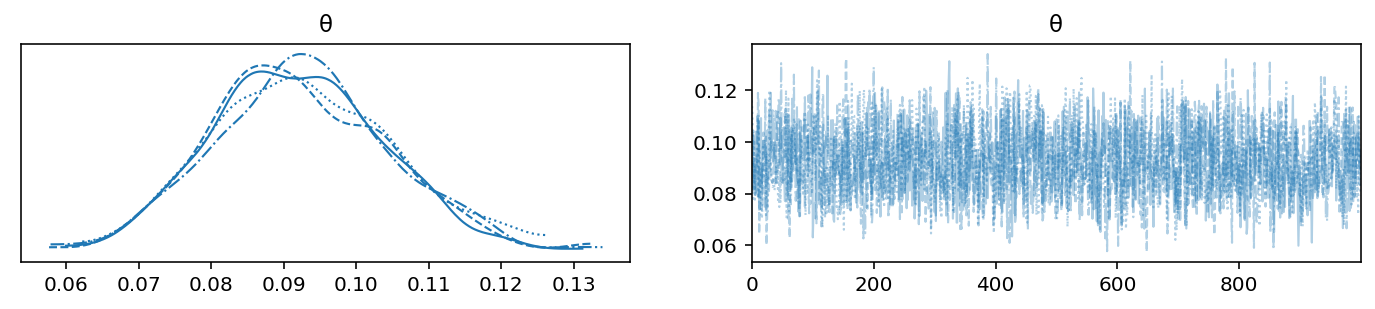

In [7]:
az.plot_trace(idata);

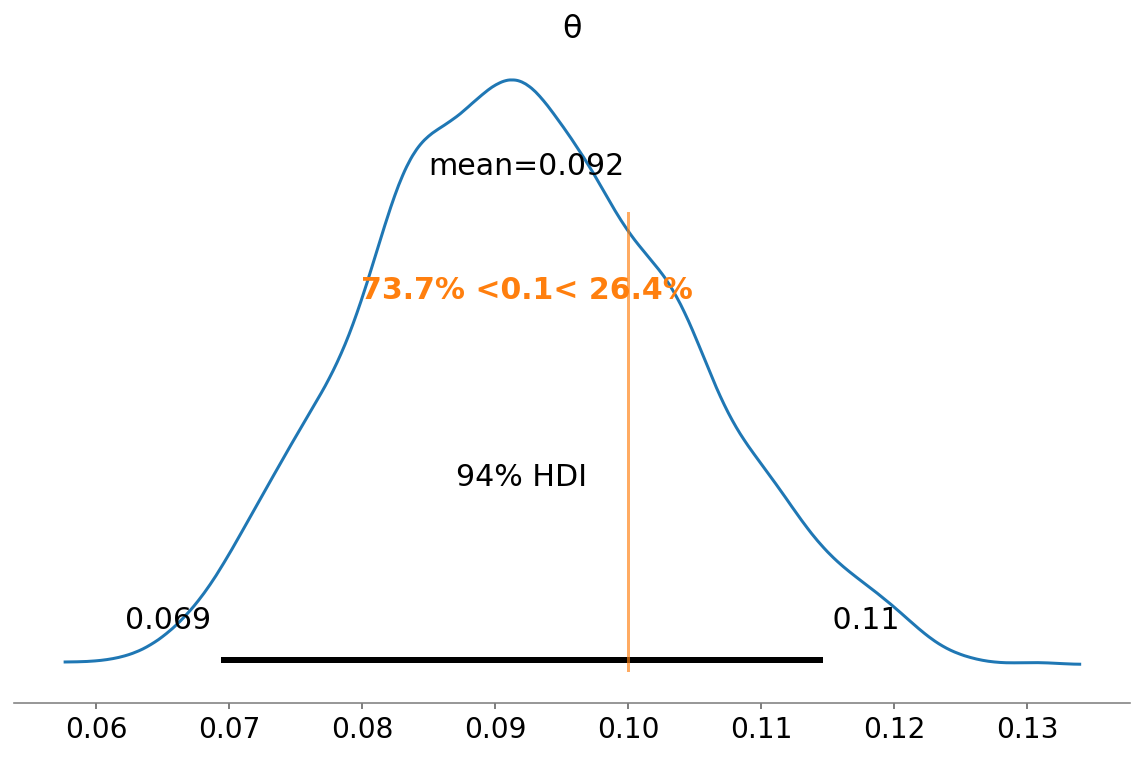

In [8]:
az.plot_posterior(idata, var_names='θ', ref_val=θtrue);

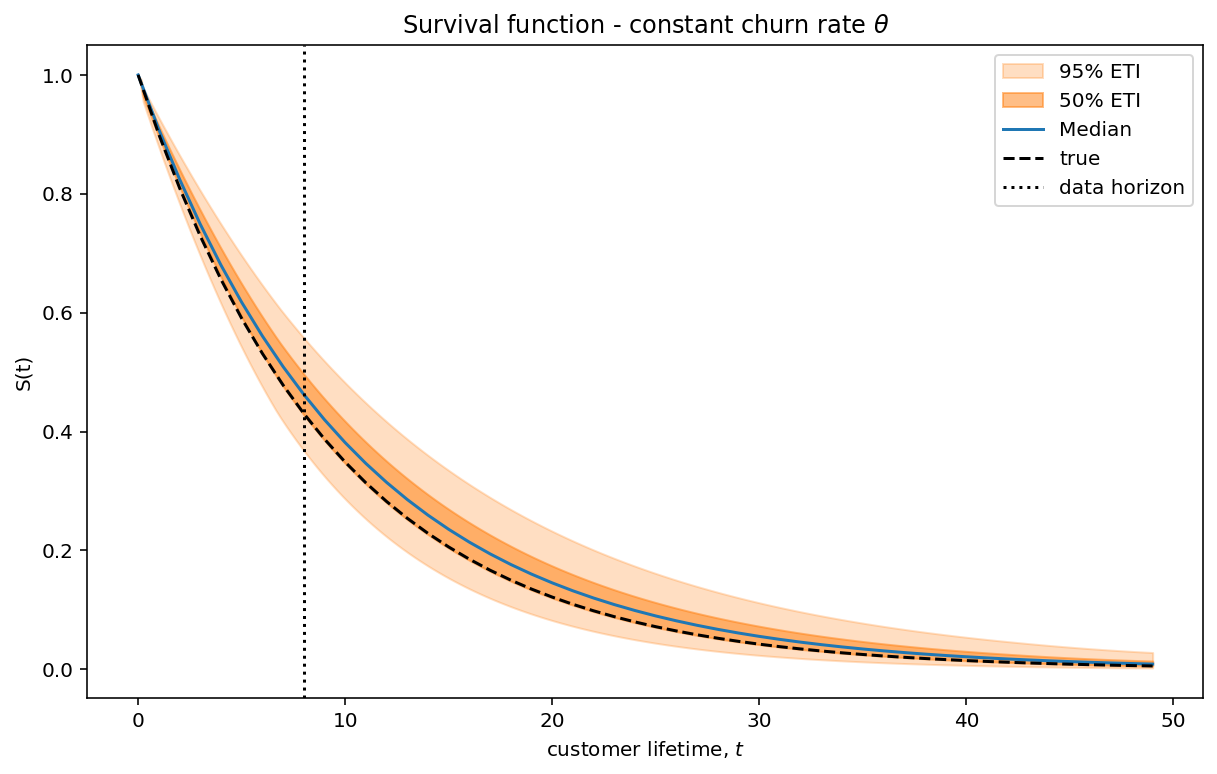

In [9]:
plot_survival_function_fixed_theta(idata.posterior.θ, θtrue=θtrue, data_horizon=len(data));

### TODO: add calculations + plots for actual CLV

## A multiple cohort sBG model in PyMC

It is pretty simple to extend what we have done to deal with multiple cohorts.

One of the main differences is that we do not just have a vector of customer counts $\vec{n}$ for a single cohort, but we will now have a list of many. So if we have $C$ cohorts then our observed numbers of cusomers are $[\vec{n_1}, \vec{n_2}, \ldots , \vec{n_C} ]$.

Remember we still have just a single churn rate parameter $\theta$ for all people in all cohorts.

$$
\begin{aligned}
\theta & \sim \text{Binomial}(1, 1) \\
\vec{n_1}, \vec{n_2}, \ldots , \vec{n_C} & \sim \text{TruncatedGeometric}(\theta)
\end{aligned}
$$

### Simulate data

In [10]:
# true churn rate per time step
θtrue = 0.2

def new_customers():
    """Generate a random number of new customers acquired in a cohort"""
    return np.round(np.random.randn() * 5 + 200)
    
data = []

cohorts = range(6)
for i, c in enumerate(reversed(cohorts)):
    initial_cohort_size = new_customers()
    n = [np.round(initial_cohort_size*((1-θtrue)**(t-1))) for t in np.arange(start=1, stop=2+c+1)]
    print(f"Cohort {i}, n = {n}")
    data.append(np.array(n))

# NOTE: At the moment the inference is problematic if we have a cohort with a single observation

Cohort 0, n = [203.0, 162.0, 130.0, 104.0, 83.0, 67.0, 53.0]
Cohort 1, n = [200.0, 160.0, 128.0, 102.0, 82.0, 66.0]
Cohort 2, n = [205.0, 164.0, 131.0, 105.0, 84.0]
Cohort 3, n = [191.0, 153.0, 122.0, 98.0]
Cohort 4, n = [200.0, 160.0, 128.0]
Cohort 5, n = [206.0, 165.0]


### The actual multiple-cohort model

In [11]:
with pm.Model() as sBG_multiple_cohort:
    θ = pm.Beta('θ', 1, 1)
    for i, cohort_data in enumerate(data):
        truncated_geometric(f"cohort{i}", cohort_data, θ)
    
# pm.model_to_graphviz(sBG_multiple_cohort)

In [12]:
with sBG_multiple_cohort:
    idata = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [θ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 10 seconds.


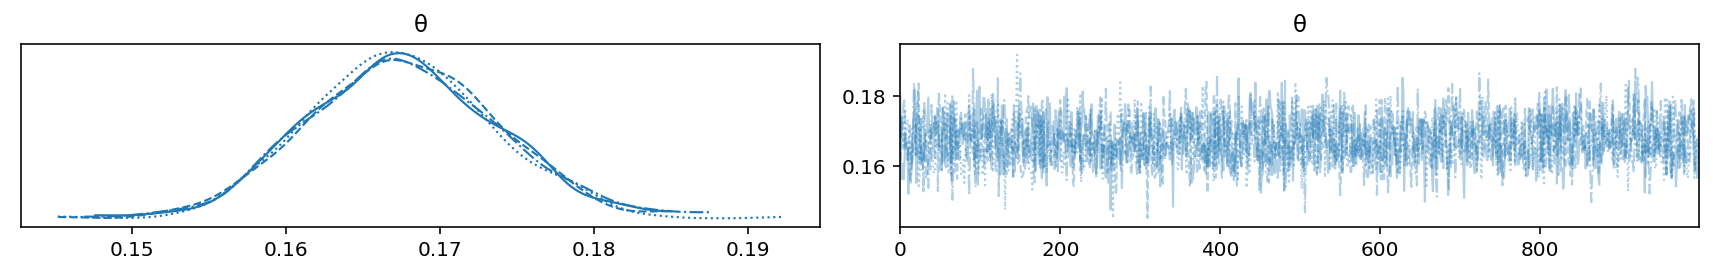

In [13]:
az.plot_trace(idata)
plt.tight_layout()

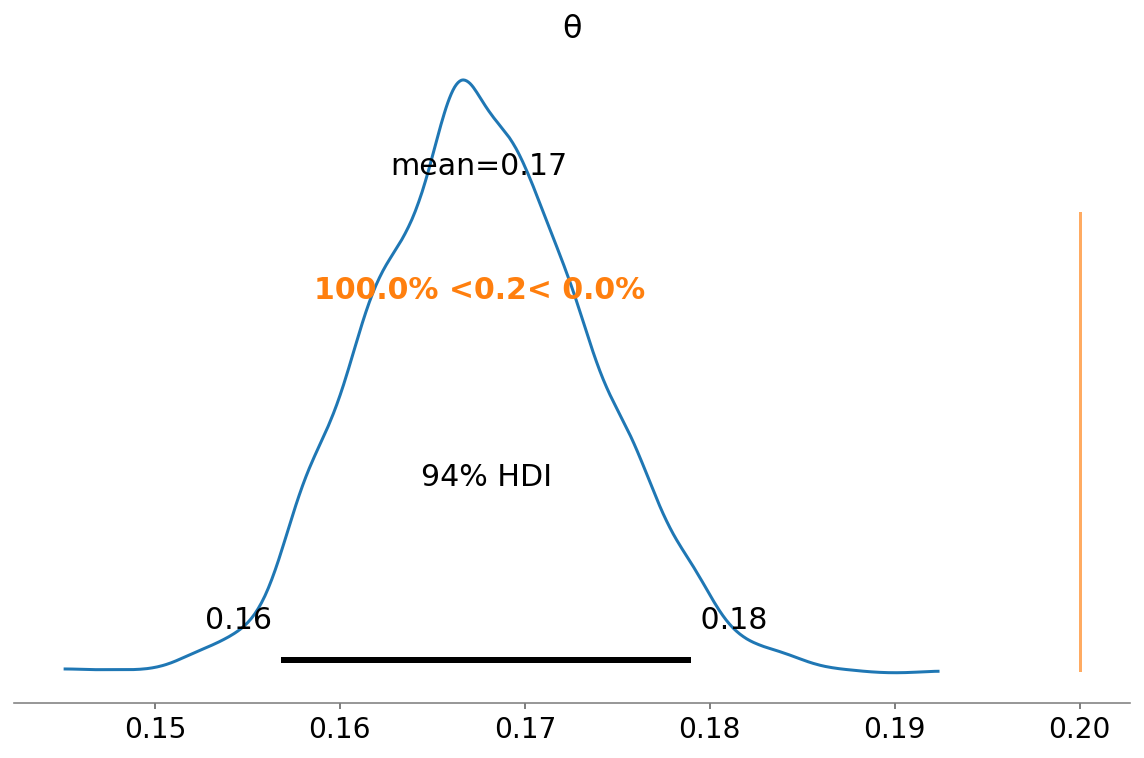

In [14]:
az.plot_posterior(idata, var_names='θ', ref_val=θtrue);

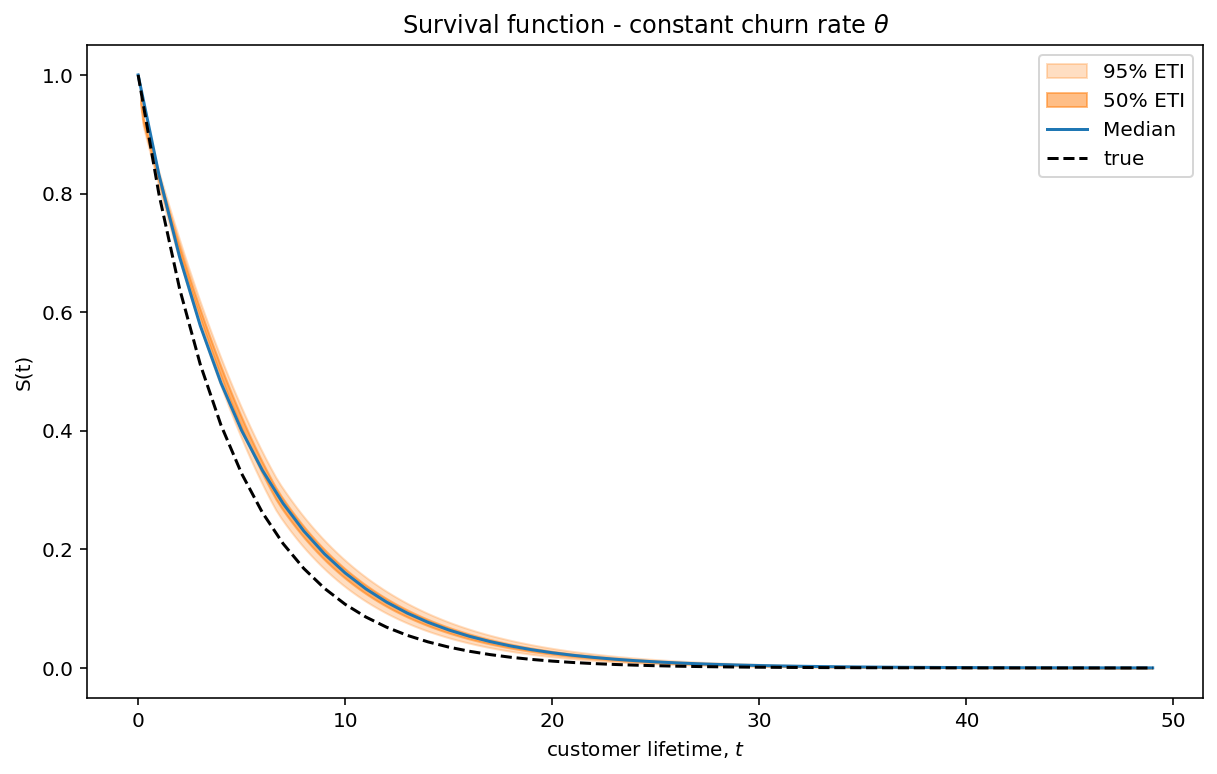

In [15]:
plot_survival_function_fixed_theta(idata.posterior.θ, θtrue=θtrue);

# WHY ARE WE UNDERESTIMATING $\theta$ ?

## Modelling cohort effects
While the previous model went from examining data from one cohort to mulitple cohorts, it still modelled all participants as having one underyling churn rate, $\theta$. 

Now things start to get even more interesting - we can model cohort effects by now estimating a value of $\theta_c$ for for cohorts $1, \ldots, C$.

In [16]:
COORDS = {'cohorts': [f"cohort{n}" for n in range(len(data))]}

with pm.Model(coords=COORDS) as sBG_theta_per_cohort:
    α = pm.Gamma('α', alpha=1, beta=1)
    β = pm.Gamma('β', alpha=1, beta=1)
    θ = pm.Beta('θ', α, β, dims='cohorts')
    for i, cohort_data in enumerate(data):
        truncated_geometric(f"cohort{i}", cohort_data, θ[i])

In [17]:
with sBG_theta_per_cohort:
    idata = pm.sample(target_accept=0.95)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
/Users/benjamv/opt/miniconda3/envs/pymmmc_env/lib/python3.8/site-packages/pymc/aesaraf.py:1005: UserWarning: The parameter 'updates' of aesara.function() expects an OrderedDict, got <class 'dict'>. Using a standard dictionary here results in non-deterministic behavior. You should use an OrderedDict if you are using Python 2.7 (collections.OrderedDict for older python), or use a list of (shared, update) pairs. Do not just convert your dictionary to this type before the call as the conversion will still be non-deterministic.
  aesara_function = aesara.function(
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [α, β, θ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 14 seconds.


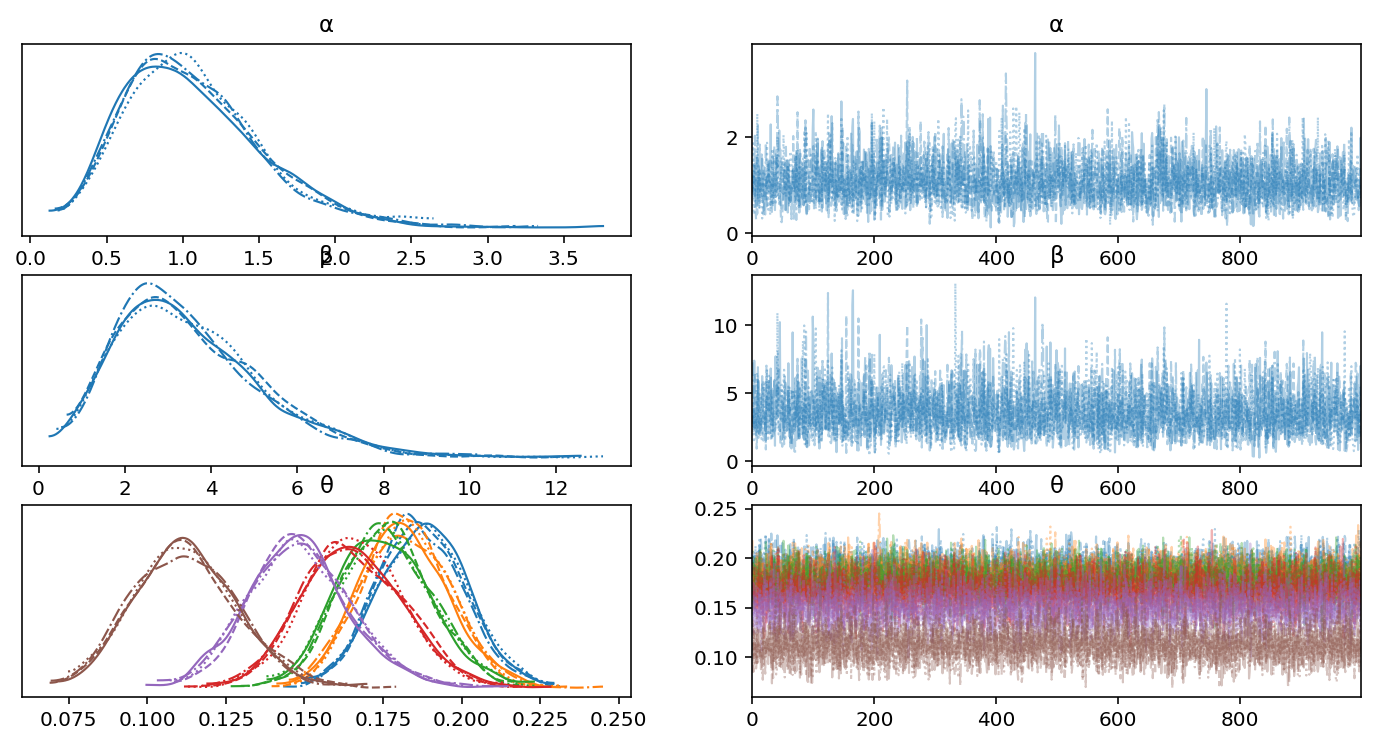

In [18]:
az.plot_trace(idata);

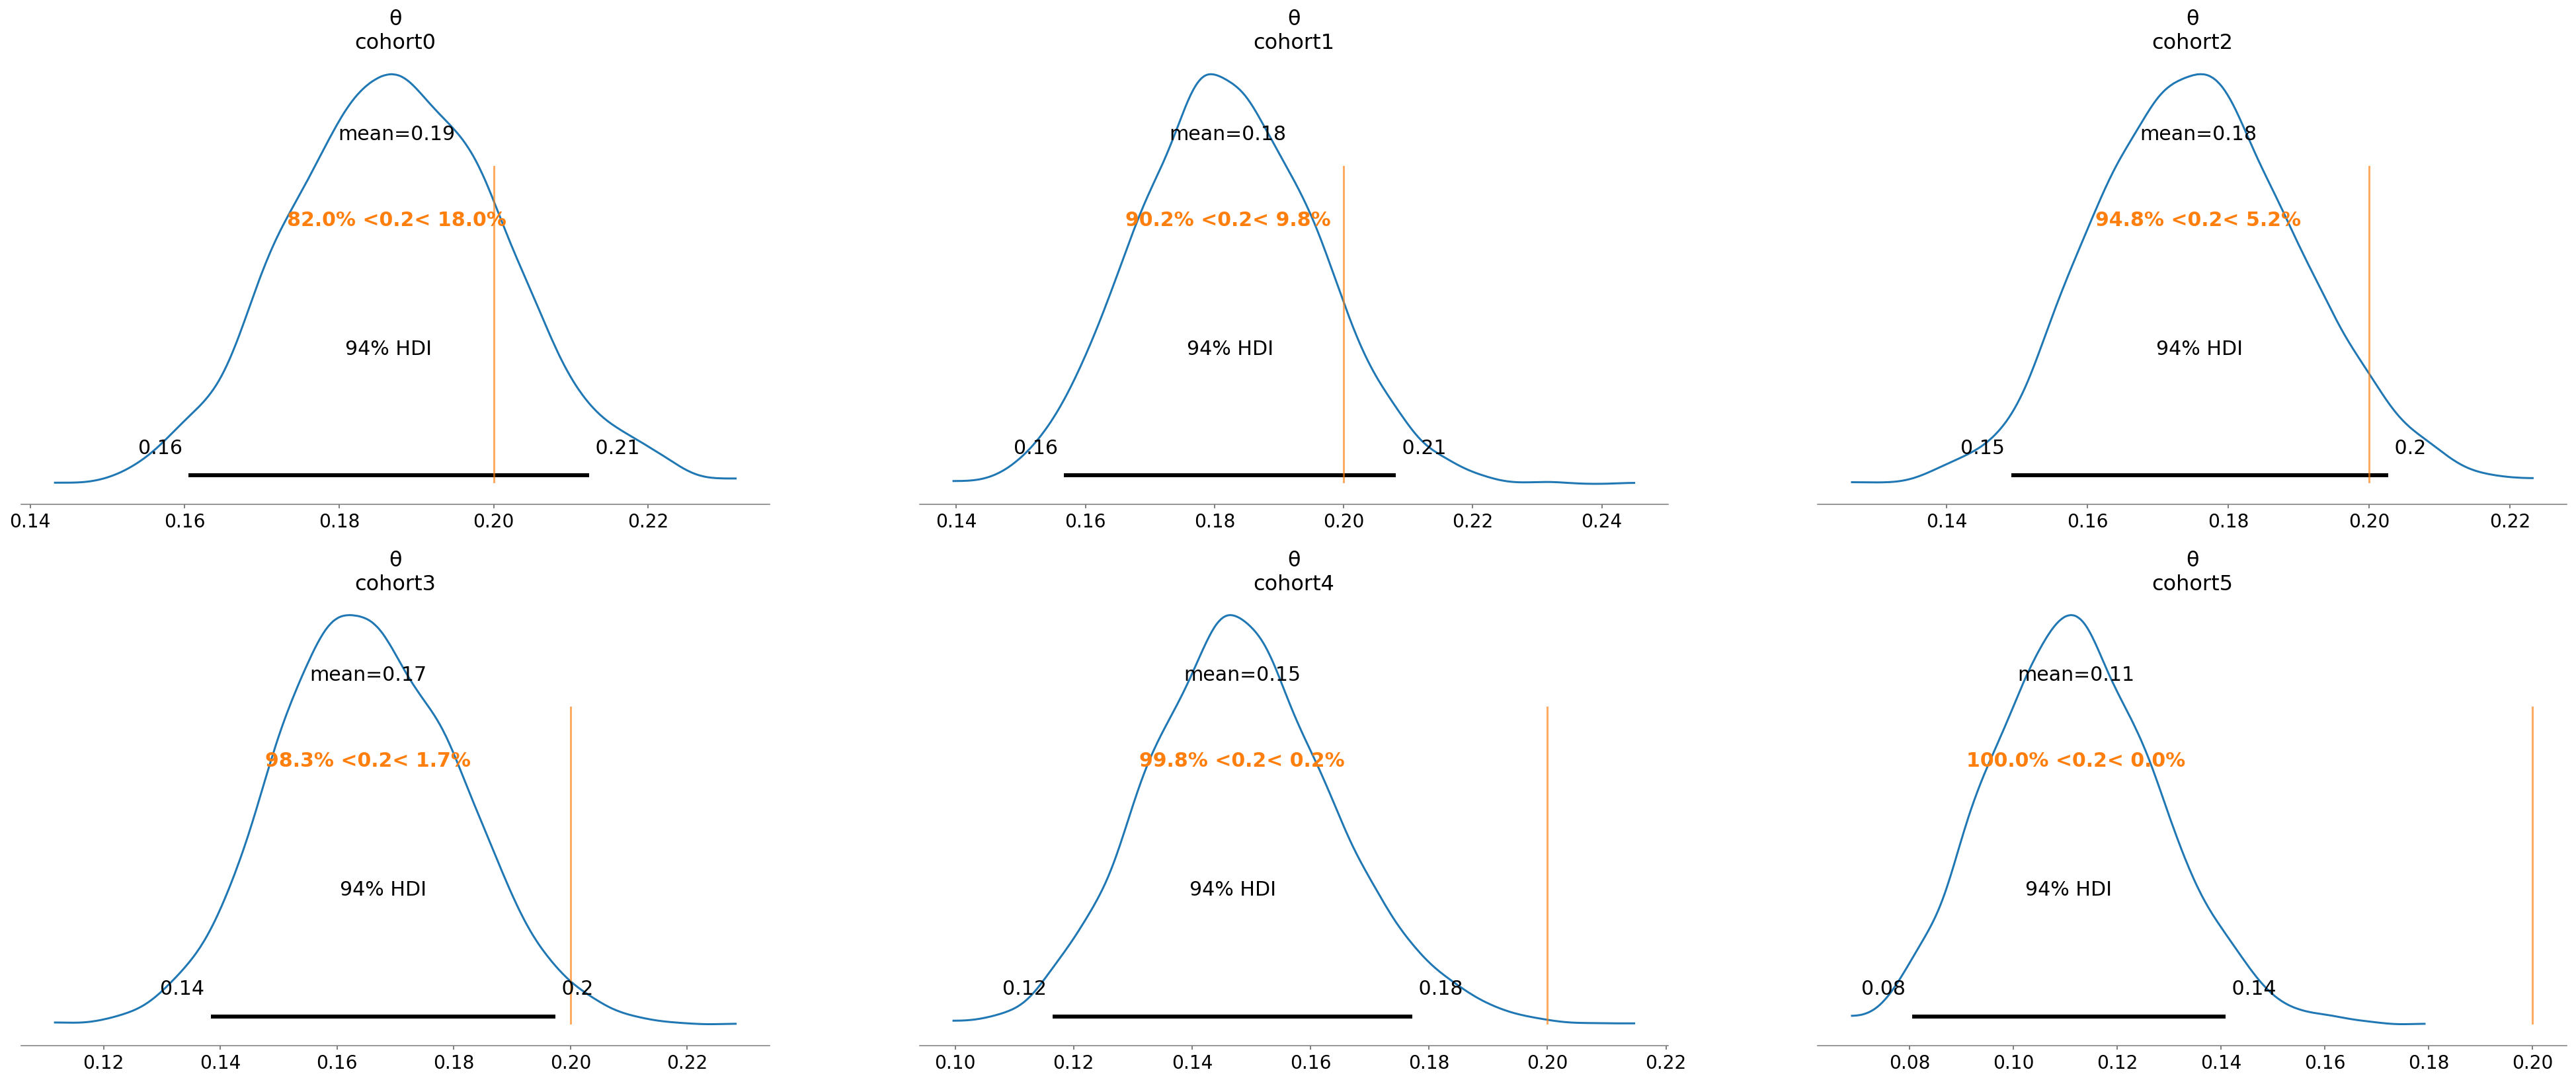

In [19]:
az.plot_posterior(idata, var_names='θ', ref_val=θtrue);

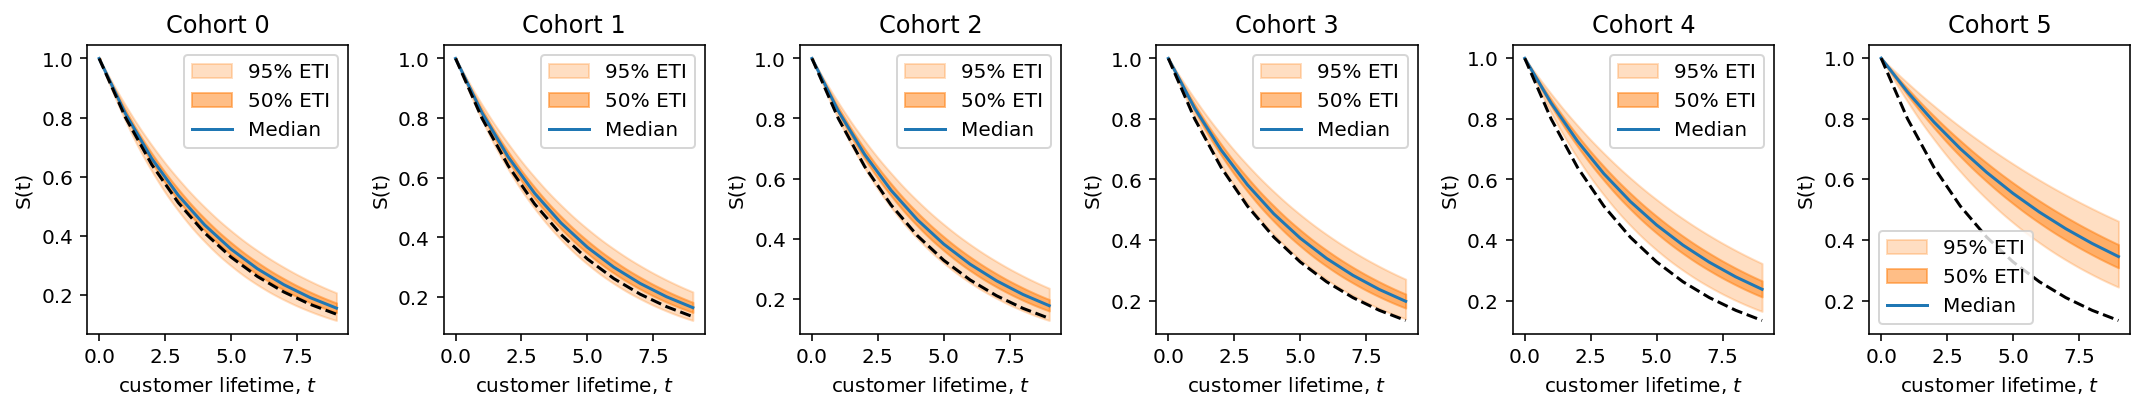

In [20]:
fig, ax = plt.subplots(1, len(data), figsize=(15, 3))

for i, c in enumerate(range(len(data))):
    plot_survival_function_fixed_theta(idata.posterior.θ.isel(cohorts=i), θtrue=θtrue, ax=ax[i], max_time=10, legend=False)
    ax[i].set(title=f"Cohort {i}")

plt.tight_layout()

## Summary
SUMMARISE THINGS HERE. Include a correct interpretation of the model.

## Related work
- See the [plexagon/lucius-ltv](https://github.com/plexagon/lucius-ltv) repo for an open source implementation of the multi-cohort sBG model

## References
- Fader & Hardie (2006) How to Project Customer Retention
- Fader & Hardie (2006) HOW TO PROJECT CUSTOMER RETENTION
- Fader & Hardie (2007) Fitting the sBG Model to Multi-Cohort Data